In [31]:
#import relevant libraries
import os
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean
from textwrap import wrap

#import dabest_2023
import dabest
#import dabest_jck
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import osar 

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

print(osar.__version__)

0.23.7


In [32]:
basegenotype = "SS95118"
responder = "Chrimson2"
wt = "w1118"
addNotes = basegenotype + " x " + responder
transgenic = addNotes
respondertype = "Chrimson2"  #for multiplots

officecomp = "C:\\Users\\Star\\"
labcomp = "C:\\Users\\User\\"
computer2 = "C:\\Users\\lnico\\"
computer3 = "D:\\"

filedirectory_OSAR = "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\DATA\\OSAR\\"
filedirectory_Falling = "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
specifiedpath = computer3

baseDirectory_OSAR = specifiedpath + filedirectory_OSAR + addNotes
baseDirectory_Falling = specifiedpath + filedirectory_Falling + addNotes

#OSAR related files
if len(addNotes) > 0:
    addNotes = "_" + addNotes   
filename_O = baseDirectory_OSAR + "\\" + basegenotype
filename_AppendDT = "_gen " + date

filename_O = filename_O + addNotes + filename_AppendDT


#Falling related files
filename_F = baseDirectory_Falling + ".csv"
filenamewt_F = specifiedpath + filedirectory_Falling + wt+"_"+ transgenic + ".csv"


filename_O

'D:\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\DATA\\OSAR\\SS95118 x Chrimson2\\SS95118_SS95118 x Chrimson2_gen 20250115'

In [33]:
#for fonts only
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = [specifiedpath + "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Programs\\"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)


for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    prop = font_manager.FontProperties(fname=font_file)

[f.name for f in matplotlib.font_manager.fontManager.ttflist]
plt.rcParams["font.family"] = "Fira Mono"

In [34]:
def singleplottingdabest(dfi, names, parameter):
    dfrr = pd.DataFrame()
    filter1 = dfi[(dfi['status'] == 'Offspring')].copy().reset_index(drop=True)
    filter2 = dfi[(dfi['status'] == 'Sibling')].copy().reset_index(drop=True)

    dfrr[names + " Cntrl" ] = filter2[parameter]
    dfrr[names] = filter1[parameter]
    #dfr1 = pd.concat([dfr1, dfrr], axis = 1)
        
    l = dfrr.columns.tolist()
    titlelst = list(zip(l,l[1:]))[::2]  
    test = dabest.load(dfrr, idx=titlelst, ci=90)    
    
    return test

# single plot

## OSAR - single plot

In [5]:
#check for border shift
osarAnalysis = osar.osar(baseDirectory_OSAR,
                        # border_shift_mm = 1.5,  
                        # countlog_folder = "countlog_Full Only",         
                        # countlog_folder = "countlog_Half and Full",
                         driver = basegenotype)

Creating borders for each fly...
Done.

Processing CSV 40 of 40
Summarising results for all flies...
All done.


In [ ]:
full_light = osarAnalysis.results[osarAnalysis.results['light_intensity'] == "Full"]
singleplottingdabest(full_light, basegenotype,'log2_speed_ratio_Pattern 01').mean_diff.plot(float_contrast=False, fontsize_rawylabel=8, fontsize_rawxlabel=8, 
                                                                      fontsize_contrastxlabel=8, fontsize_contrastylabel=8, raw_marker_size=2, es_marker_size=6, 
                                                                      custom_palette="Paired", swarm_label="Log2 speed ratio", contrast_ylim=(-1.5,1.5));

In [64]:
speed_osar = float(singleplottingdabest(full_light, basegenotype,'log2_speed_ratio_Pattern 01').mean_diff.statistical_tests['difference'])
speed_osar

0.4373069087457313

## Falling - single plot

In [108]:
def full_lightreplace(df, basegenotype):
    df = df.replace("Full", "Light")
    #df['genre']= df['genre'].replace("Full", "Light")
    df['Type'] = df['Type'].replace("Expt", basegenotype) 

    return df

In [89]:
dfe=pd.read_csv(filename_F)
dfw= pd.read_csv(filenamewt_F)

exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

dfexpt = NLCLIMB.generation(exptdf, basegenotype)
dfwt = NLCLIMB.generation(wtdf, wt)

In [126]:
df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
df_sp1 = full_lightreplace(df_sp.copy(), basegenotype)
df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
df_bsp1 = full_lightreplace(df_bsp.copy(), basegenotype)

dftotal = pd.DataFrame()

dfs2 = NLMATH.deltaversion(df_sp, basegenotype, "Velocity")
dfs2['Genre'] = "Speed"

dfbs2 = NLMATH.deltaversion(df_bsp, basegenotype, "BSpeed")
dfbs2['Genre'] = "Bout_speed"

dftotal_falling = pd.concat([dfs2, dfbs2], axis = 0).reset_index(drop=True)
dftotal_falling['Assay'] = "Falling"

In [ ]:
figfirstplot, axs = plt.subplots(1,2, figsize=(20, 8),sharex = "col")

speedplots = dabest.load(data=df_sp1, x=["ExperimentState","Type"], y="Velocity", delta2 = True, experiment="Type", 
                             experiment_label = ["WT", basegenotype], x1_level = ["Dark","Light"], paired = "baseline", id_col = "index")
speedplots.delta_g.plot(swarm_label="Speed",
                                    contrast_label="Δ Speed", swarm_ylim = (0,25),  contrast_ylim=(-2, 2),fontsize_rawxlabel=7, fontsize_rawylabel=10, fontsize_contrastxlabel=10, 
                                    fontsize_contrastylabel=10, fontsize_delta2label=10,
                                    ax=axs.flat[0]);

boutspeed_plots = dabest.load(data=df_bsp1, x=["ExperimentState","Type"], y="BSpeed", delta2 = True, experiment="Type", 
                             experiment_label = ["WT", basegenotype], x1_level = ["Dark","Light"], paired = "baseline", id_col = "index")
boutspeed_plots.delta_g.plot(swarm_label="Bout Speed",
                                    contrast_label="Δ Bout Speed", swarm_ylim = (0,25),  contrast_ylim=(-2, 2),fontsize_rawxlabel=7, fontsize_rawylabel=10, fontsize_contrastxlabel=10, 
                                    fontsize_contrastylabel=10, fontsize_delta2label=10,
                                    ax=axs.flat[1]);

# multiplot

## osar - multiplot

In [40]:
filepath_cr2 = "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\DATA\\osar_test\\Chrimson2 20250115_compilation_full.csv"
dfcr2= pd.read_csv(specifiedpath + filepath_cr2)

filepath_acr = "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\DATA\\osar_test\\ACR 20250115_compilation_full.csv"
dfacr= pd.read_csv(specifiedpath + filepath_acr)

genotypescr2 = dfcr2['driver'].unique()
genotypesacr = dfacr['driver'].unique()

#dfi=dfcr2[(dfcr2['light_intensity']=='Half') | (dfcr2['light_intensity']=='Full')].copy()
dfi_cr2=dfcr2[(dfcr2['light_intensity']=='Full')].copy()
dfi_cr2.replace([np.inf, -np.inf], np.nan, inplace=True)
dfi_cr2.rename(columns={'driver': 'MBON'}, inplace = True)


dfi_acr=dfacr[(dfacr['light_intensity']=='Full')].copy()
dfi_acr.replace([np.inf, -np.inf], np.nan, inplace=True)
dfi_acr.rename(columns={'driver': 'MBON'}, inplace = True)

In [41]:
def chartplottingdabest(dfi, basegenotype, parameter):
    
    dfr1 = pd.DataFrame()
    for names in basegenotype:
        dfrr = pd.DataFrame()
        filter1 = dfi[(dfi['MBON'] == names) & (dfi['status'] == 'Offspring')].copy().reset_index(drop=True)
        filter2 = dfi[(dfi['MBON'] == names) & (dfi['status'] == 'Sibling')].copy().reset_index(drop=True)

        dfrr[names + " Cntrl" ] = filter2[parameter]
        dfrr[names] = filter1[parameter]
        dfr1 = pd.concat([dfr1, dfrr], axis = 1)
        
    l = dfr1.columns.tolist()
    titlelst = list(zip(l,l[1:]))[::2]  
    
    test = dabest.load(dfr1, idx=titlelst, ci=90)    
    tab = pd.concat([test.mean_diff.results['test'], test.mean_diff.results['difference']], axis = 1)
    
    arrangedsorting = tab.sort_values(by=['difference'], ascending = True).reset_index(drop=True)

    newlist = []
    for n in arrangedsorting['test']:
        newlist.append((n +" Cntrl", n))

    return dfr1, arrangedsorting['test'], newlist

def osarmultiplottable(df):
    osar_multiplot = pd.DataFrame()
    osar_multiplot['MBON'] = df.mean_diff.statistical_tests['test']
    osar_multiplot['osar_speed'] = df.mean_diff.statistical_tests['difference']
    return osar_multiplot

In [42]:
#cr2
# dfpi_cr2, sortedlist_cr2, dabestlist_cr2 = chartplottingdabest(dfi_cr2, genotypescr2, 'pi_smoothed_Pattern 01')
# dfspeed_cr2, notsortedlist_cr2, notdabestlist_cr2 = chartplottingdabest(dfi_cr2, genotypescr2, 'log2_speed_ratio_Pattern 01')

#acr
dfpi_acr, sortedlist_acr, dabestlist_acr = chartplottingdabest(dfi_acr, genotypesacr, 'pi_smoothed_Pattern 01')
dfspeed_acr, notsortedlist_acr, notdabestlist_acr = chartplottingdabest(dfi_acr, genotypesacr, 'log2_speed_ratio_Pattern 01')

In [43]:
# speed_cr2plot = dabest.load(dfspeed_cr2, idx=dabestlist_cr2, ci=90)
speed_acrplot = dabest.load(dfspeed_acr, idx=dabestlist_acr, ci=90)

#osar_multiplot_cr2 = osarmultiplottable(speed_cr2plot)
osar_multiplot_acr = osarmultiplottable(speed_acrplot)



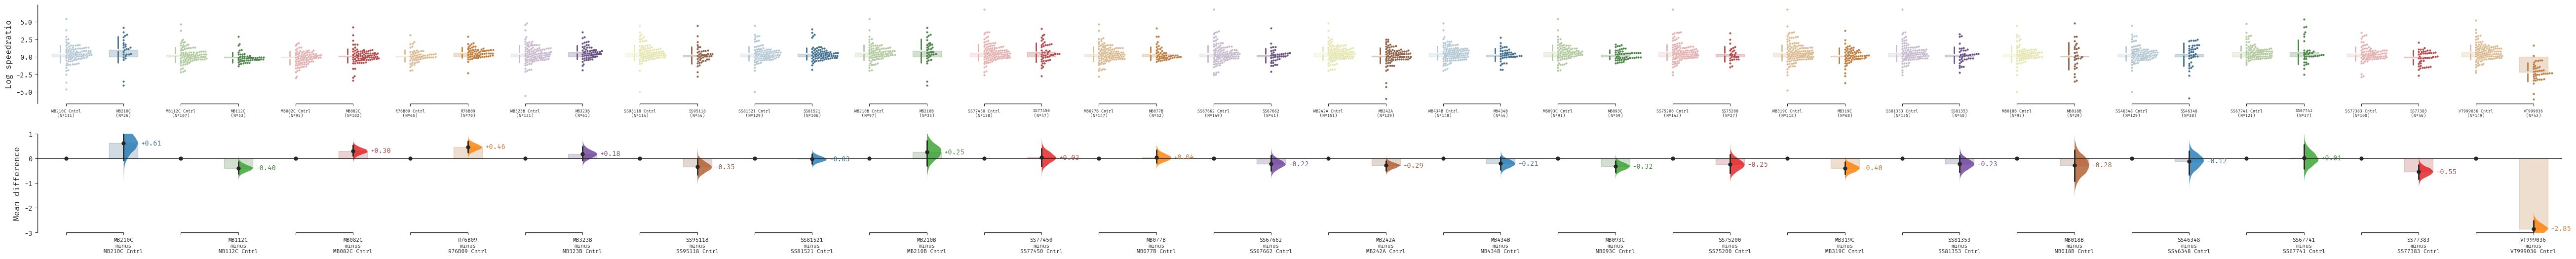

In [46]:
speed_acrplot.mean_diff.plot(fontsize_rawxlabel=6, fontsize_contrastxlabel=8, float_contrast=False, raw_marker_size=1, es_marker_size=5, 
                      custom_palette="Paired", swarm_label="Log Speedratio", contrast_ylim=(-3,1));

#sns.set(font_scale=0.5,  style='ticks')

## Falling - multiplot

In [19]:
def generating_heatmapdf(responder, dflists2):
    
    
    newfile2 = specifiedpath + "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\Compilation with delta\\20241014collection\\"
    files2 = os.listdir(newfile2)

    for labels in dflists2:
        newfileread = pd.DataFrame()
        for yy in files2:
            if yy.split(" ")[3] == labels and responder in yy:
                newfile2read = pd.read_csv(newfile2 + yy)
                newfileread = pd.concat([newfileread, newfile2read])
        globals()[labels] = (newfileread.set_index("MBON"))
        
    #generating list of MBONS
    MBONList = []
    for yy in files2:
        MBONList.append(yy.split(" ")[0])

    MBONList = list(set(MBONList))
    
    #processing
    dfreg2 = pd.DataFrame()
    for n in MBONList:
        dfreg = pd.DataFrame()
        dfreg["Bout speed"] = dfreg_bspeed[dfreg_bspeed.index == n]['delta_g']
        dfreg["Speed"] = dfreg_speed[dfreg_speed.index == n]['delta_g']
        # dfreg["Fall #"] = dfreg_fall[dfreg_fall.index == n]['delta_g']
        # dfreg["Height"] = dfreg_height[dfreg_height.index == n]['delta_g']
        # #dfreg["Time to reach 3/4 chamber"] = dfreg_time[dfreg_time.index == n]['delta_g']
        # # dfreg["Mean\n Pause"] = dfreg_meanpause[dfreg_meanpause.index == n]['delta_g']
        # # dfreg["Pause #"] = dfreg_pause[dfreg_pause.index == n]['delta_g']
        # dfreg["Mean Bout"] = dfreg_meanbout[dfreg_meanbout.index == n]['delta_g']
        # dfreg["Bout #"] = dfreg_bout[dfreg_bout.index == n]['delta_g']
        # #dfreg["Bout position"] = dfreg_boutpos[dfreg_boutpos.index == n]['delta_g']
        # # dfreg["Pause\n position"] = dfreg_pausepos[dfreg_pausepos.index == n]['delta_g']
        # #new features
        # dfreg["Max Speed"] = dfreg_maxvelocity[dfreg_maxvelocity.index == n]['delta_g']
        # dfreg["Avg Straightness index"] = dfreg_straightindex[dfreg_straightindex.index == n]['delta_g']
        # dfreg["displacement between pause"] = dfreg_displacementbetweenpause[dfreg_displacementbetweenpause.index == n]['delta_g']
        
        # dfreg["Ascending dist"] = dfreg_ascent[dfreg_ascent.index == n]['delta_g']
        # dfreg["Descending dist"] = dfreg_descent[dfreg_descent.index == n]['delta_g']
        dfreg['MBON'] = n
        dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)
        
    return dfreg2

def find_number(df, lookup_value, genre):
    lobe_values = []
    for _, row in df.iterrows():
        # Splitting the 'MBON' values and removing any potential whitespace
        mbon_values = [x.strip() for x in row['MBON names'].split(',')]
        if lookup_value in mbon_values:
            lobe_values.append(row[genre])
            
    lobelobe = list(set(lobe_values))
    return ', '.join(lobelobe)

def matchingdfs (df, matchingset):
    newdf_a = pd.DataFrame()
    for n in matchingset:
        df_a=pd.DataFrame()
        df_a = df[(df['MBON'] == n)]
        newdf_a = pd.concat([newdf_a, df_a]).reset_index(drop=True)
    return newdf_a

import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
def matchinglobesets(dfreg_a, lobelocation):
    lobelocation_a = lobelocation.sort_values(by=['MBON']).reset_index(drop=True)
    dfreg_a_withloc = dfreg_a.sort_values(by=['MBON']).reset_index(drop=True)
    matchinglobereg = list(set(lobelocation_a['MBON']) & set(dfreg_a_withloc['MBON']))

    dflobe_reg = matchingdfs(lobelocation_a, matchinglobereg).sort_values(by=['MBON']).reset_index(drop=True)

    dfreg_a_withloc['Lobe_location'] = dflobe_reg['Lobe_location']
    dfreg_a_withloc['MBON number'] = dflobe_reg['MBON number']
    dfreg_a_withloc['Neurotransmitter'] = dflobe_reg['Neurotransmitter']

    return dfreg_a_withloc

In [20]:
#lobe location

newfile2 = specifiedpath + "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\Compilation with delta\\20241014collection\\"
files2 = os.listdir(newfile2)

MBONList = []
for yy in files2:
    MBONList.append(yy.split(" ")[0])

MBONList = list(set(MBONList))

#reading mbonlist file
directorynew = os.path.dirname(os.path.dirname(specifiedpath + "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\")) #goes up one directory
fileinnewdirc = os.listdir(directorynew)

for file_no2 in fileinnewdirc:
    if ".csv" in file_no2:
        ff = os.path.join(directorynew, file_no2)
        csvfile = pd.read_csv(ff)

csvfile = csvfile.astype('string')

for n, k in zip(["B", "y", "a"], ['β', "γ", "α"]):
    csvfile['Lobe'] = csvfile['Lobe'].str.replace(n, k)

lobelocation = pd.DataFrame()

for m in MBONList:
    lobeloc = pd.DataFrame()
    unqlist = []
    lobeloc['MBON'] = [m]
    loclst = find_number(csvfile, m, "Lobe")
    mbonlst = find_number(csvfile, m, "MBON number").strip()
    ntlst = find_number(csvfile, m, "Neurotransmitter")
    lobeloc['Lobe_location'] = [loclst]
    lobeloc['MBON number'] = [mbonlst]
    lobeloc['Neurotransmitter'] = [ntlst]
    
    lobelocation = pd.concat([lobelocation, lobeloc])

lobelocation = lobelocation.reset_index(drop=True)

In [21]:
#dflists = ['df_bspeed', 'df_speed', 'df_time', 'df_fall','df_height', 'df_displacement', 'df_meanpause', 'df_pause','df_meanbout', 'df_bout','df_boutpos', 'df_pausepos','df_maxvelocity','df_straightindex', 'df_displacementbetweenpause', "df_ascent", "df_descent"]
dflists = ['df_bspeed', 'df_speed']
dflists2 = [s.replace('df_', 'dfreg_') for s in dflists]

dflists2 = [s.replace('df_', 'dfreg_') for s in dflists]
dfreg_Cr2 = generating_heatmapdf("Chrimson2", dflists2).sort_values('MBON').reset_index(drop=True)
dfreg_ACR = generating_heatmapdf("ACR", dflists2).sort_values('MBON').reset_index(drop=True)

In [22]:
#matching OSAR to falling MBONS
#matchingset = list(set(dfreg_Cr2['MBON']) & set(osar_multiplot['MBON']))
matchingsetA = dfreg_ACR['MBON']
matchingsetC = dfreg_Cr2['MBON']

dfreg_a = matchingdfs(dfreg_ACR, matchingsetA)
dfreg_c = matchingdfs(dfreg_Cr2, matchingsetC)
# osar_multiplotmatched = matchingdfs(osar_multiplot, matchingset)

dfreg_a['responder'] = dfreg_a['MBON']+"_ACR"
dfreg_c['responder'] = dfreg_c['MBON']+"_CsChrimson"

In [ ]:
#mini list of only SPECIFIC responder

responder = "Chrimson2"

if responder == 'Chrimson2':
    responderrename = "CsChrimson"
    dfreg_specificresponder = dfreg_c.sort_values(by = "responder", ascending=True).reset_index(drop=True)

if responder == 'ACR':
    responderrename = "GtACR1"
    dfreg_specificresponder = dfreg_a.sort_values(by = "responder", ascending=True).reset_index(drop=True)

plt.rcParams["font.family"] = "Fira Mono"

lstofmbonsiwant = MBONList
df_specificmbon = pd.DataFrame()
for n in lstofmbonsiwant:
    df_specificmbon = pd.concat([df_specificmbon, dfreg_specificresponder[dfreg_specificresponder['MBON'] == n]])
    
df_specificmbon = df_specificmbon.reset_index(drop=True)
df60 = df_specificmbon.set_index(['MBON'])
df60 = df60.drop(['responder'], axis =1)
fig1, ax4 = plt.subplots(figsize=(6, 6))     

#adding extra axes label
lobloclst = []
mbonloclst = []
for n in df_specificmbon['MBON']:
    df600 = df_specificmbon.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df600['Lobe'] = lobloclst
df600['Name'] = mbonloclst

df600 = df600.sort_values(by = "Name", ascending=True).reset_index(drop=True)
df60extra = df600.iloc[:,:-3].set_index('MBON')   #change depending on parameters

newdf600 = pd.DataFrame()
naming = df600['Name'].to_frame().rename(columns = {"Name": ""})
lobing = df600['Lobe'].to_frame().rename(columns = {"Lobe": ""})
newlabel =(naming.values + "\n " + lobing.values).tolist()
newdf600['Merge'] = newlabel

#colorbar
cax = inset_axes(ax4,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.2, 1.15, 1, 1),
                 bbox_transform=ax4.transAxes,
                 borderpad=-2,
                 )

sns.set_style("whitegrid", {'axes.grid' : False})    
       
j7 = sns.heatmap(df60extra, ax = ax4, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='bwr', linewidths=0.0, edgecolor = "none"
                 , clip_on=False, cbar_ax=cax, cbar_kws = dict(orientation = "horizontal", ticks = [-1.5,0,1.5]), annot_kws={"size": 12, }) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #cbar_kws = dict(orientation = "vertical")
#twilight_shifted also a possible color

j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 10)
#j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 12)
j7.set_xticklabels(['Original_Boutspeed', 'Original_Speed'], rotation = 0, fontsize = 8)

wrap_labels(j7, 10)

# Drawing the frame 
j7.axhline(y = 0, color = 'k',  
            linewidth = 5) 
  
j7.axhline(y = 10, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 0, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 11, color = 'k', 
            linewidth = 5) 

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())


#y labels for mbon lobes and naming
labellinglist = newdf600['Merge'].iloc[::-1]
labelledlist = []
for n in labellinglist:
    labelledlist.extend(n)
    #inserts blank space after every list name
j8.set_yticklabels(labelledlist, fontsize=8)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)

j7.set_title('Plot of MBONs > ' + responderrename +' and their Δg across\n locomotor reactivity parameters', x=0.5, weight='bold', fontsize =11)

fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations.png", dpi = 1200)

# Comparison models

## Direct comparison (Falling delta g and OSAR delta)

In [143]:
#single plot only
df_directcomp = pd.DataFrame()

df_directcomp['osar_speed'] = [speed_osar]
df_directcomp['falling_speed'] = dftotal_falling[dftotal_falling['Genre'] == "Speed"]["delta_g"].reset_index(drop=True)
df_directcomp['falling_boutspeed'] = dftotal_falling[dftotal_falling['Genre'] == "Bout_speed"]["delta_g"].reset_index(drop=True)
df_directcomp['MBON'] = basegenotype


df_directcomp

,osar_speed,falling_speed,falling_boutspeed,MBON
0,0.437307,-0.421,0.135,SS95118


In [18]:
def matchingcomp(df, df2):
    matchingset = list(set(dfreg_Cr2['MBON']) & set(osar_multiplot_cr2['MBON']))
    newdf_a = pd.DataFrame()
    for n in matchingset:
        df_a=pd.DataFrame()
        df_a = df[(df['MBON'] == n)]
        df_b = pd.merge(df_a, df2, on = "MBON" )
        newdf_a = pd.concat([newdf_a, df_b]).reset_index(drop=True)
        
    return newdf_a

In [23]:
#matching OSAR to falling MBONS

dfreg_co = matchingcomp(dfreg_Cr2, osar_multiplot_cr2)
dfreg_co['responder'] = dfreg_co['MBON']+"_CsChrimson"

dfreg_ao = matchingcomp(dfreg_ACR, osar_multiplot_acr)
dfreg_ao['responder'] = dfreg_ao['MBON']+"_GtACR1"

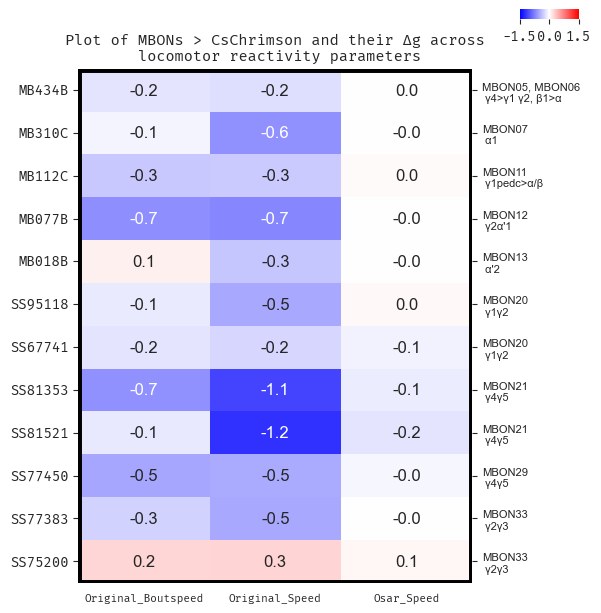

In [25]:
#mini list of only SPECIFIC responder

responder = "Chrimson2"

if responder == 'Chrimson2':
    responderrename = "CsChrimson"
    dfreg_specificresponder = dfreg_co.sort_values(by = "responder", ascending=True).reset_index(drop=True)

if responder == 'ACR':
    responderrename = "GtACR1"
    dfreg_specificresponder = dfreg_ao.sort_values(by = "responder", ascending=True).reset_index(drop=True)

plt.rcParams["font.family"] = "Fira Mono"

lstofmbonsiwant = MBONList
df_specificmbon = pd.DataFrame()
for n in lstofmbonsiwant:
    df_specificmbon = pd.concat([df_specificmbon, dfreg_specificresponder[dfreg_specificresponder['MBON'] == n]])
    
df_specificmbon = df_specificmbon.reset_index(drop=True)
df60 = df_specificmbon.set_index(['MBON'])
df60 = df60.drop(['responder'], axis =1)
fig1, ax4 = plt.subplots(figsize=(6, 6))     

#adding extra axes label
lobloclst = []
mbonloclst = []
for n in df_specificmbon['MBON']:
    df600 = df_specificmbon.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df600['Lobe'] = lobloclst
df600['Name'] = mbonloclst

df600 = df600.sort_values(by = "Name", ascending=True).reset_index(drop=True)
df60extra = df600.iloc[:,:-3].set_index('MBON')   #change depending on parameters

newdf600 = pd.DataFrame()
naming = df600['Name'].to_frame().rename(columns = {"Name": ""})
lobing = df600['Lobe'].to_frame().rename(columns = {"Lobe": ""})
newlabel =(naming.values + "\n " + lobing.values).tolist()
newdf600['Merge'] = newlabel

#colorbar
cax = inset_axes(ax4,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.2, 1.15, 1, 1),
                 bbox_transform=ax4.transAxes,
                 borderpad=-2,
                 )

sns.set_style("whitegrid", {'axes.grid' : False})    
       
j7 = sns.heatmap(df60extra, ax = ax4, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='bwr', linewidths=0.0, edgecolor = "none"
                 , clip_on=False, cbar_ax=cax, cbar_kws = dict(orientation = "horizontal", ticks = [-1.5,0,1.5]), annot_kws={"size": 12, }) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #cbar_kws = dict(orientation = "vertical")
#twilight_shifted also a possible color

j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 10)
#j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 12)
j7.set_xticklabels(['Original_Boutspeed', 'Original_Speed', 'Osar_Speed'], rotation = 0, fontsize = 8)

wrap_labels(j7, 10)

# Drawing the frame 
j7.axhline(y = 0, color = 'k',  
            linewidth = 5) 
  
j7.axhline(y = 12, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 0, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 3, color = 'k', 
            linewidth = 5) 

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())


#y labels for mbon lobes and naming
labellinglist = newdf600['Merge'].iloc[::-1]
labelledlist = []
for n in labellinglist:
    labelledlist.extend(n)
    #inserts blank space after every list name
j8.set_yticklabels(labelledlist, fontsize=8)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)

j7.set_title('Plot of MBONs > ' + responderrename +' and their Δg across\n locomotor reactivity parameters', x=0.5, weight='bold', fontsize =11)

fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations.png", dpi = 1200)

## Falling to Log speed ratio (single and multiplot)

In [ ]:
## will look at overall speed/fly in light - overall speed/fly in darkimport math

#single fly only
import math

dfe=pd.read_csv(filename_F)
dfw= pd.read_csv(filenamewt_F)

exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

dfexpt = NLCLIMB.generation(exptdf, basegenotype)
dfwt = NLCLIMB.generation(wtdf, wt)

df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
df_srfalling = pd.DataFrame()
for n in df_sp['index'].unique().tolist():
    df_temp = pd.DataFrame()
    sectioned = df_sp[df_sp['index']==n]
    darkvalue = float(sectioned[sectioned["ExperimentState"] == "Dark"]['Velocity'])
    lightvalue = float(sectioned[sectioned["ExperimentState"] == "Full"]['Velocity'])
    speedratio = math.log2(lightvalue/darkvalue)
    df_temp["Name"] = [n]
    df_temp["Speedratio"] = [speedratio]
    df_temp["Type"] = sectioned["Type"].unique().tolist()
    df_srfalling = pd.concat([df_srfalling, df_temp])

df_srfalling = df_srfalling.replace("Expt", basegenotype)

# figsecondplot, axs1 = plt.subplots(1,2, figsize=(12, 8),sharex = "col", gridspec_kw={'wspace': 0.3})

# fallingtosarplots = dabest.load(df_srfalling, idx = ("WT", basegenotype), x= "Type", y = "Speedratio")
# fallingtosarplots.mean_diff.plot(float_contrast=False, raw_marker_size=1, swarm_ylim = (-2,2), contrast_ylim=(-1, 1), fontsize_rawxlabel=8, fontsize_rawylabel=9, fontsize_contrastxlabel=8, 
#                                     fontsize_contrastylabel=8, custom_palette={"WT" : 'lightcoral', basegenotype :'brown'}, swarm_label="Falling LogSR\n" + basegenotype, ax=axs1.flat[0]);

# singleplottingdabest(full_light, basegenotype,'log2_speed_ratio_Pattern 01').mean_diff.plot(float_contrast=False, fontsize_rawylabel=8, fontsize_rawxlabel=8, swarm_ylim = (-2,2), contrast_ylim=(-1, 1),
#                                                                       fontsize_contrastxlabel=8, fontsize_contrastylabel=8, raw_marker_size=2, es_marker_size=6, 
#                                                                       custom_palette={basegenotype + " Cntrl" : 'lightcoral', basegenotype :'brown'}, swarm_label="OSAR LogSR\n" + basegenotype, ax=axs1.flat[1]);

In [13]:
# multiplot
def speedratiocalc(df, genotype):
    df_srfalling = pd.DataFrame()
    df_tab = pd.DataFrame()
    for n in df_sp['index'].unique().tolist():
        
        df_temp = pd.DataFrame()
        sectioned = df_sp[df_sp['index']==n]
        darkvalue = float(sectioned[sectioned["ExperimentState"] == "Dark"]['Velocity'])
        lightvalue = float(sectioned[sectioned["ExperimentState"] == "Full"]['Velocity'])
        speedratio = math.log2(lightvalue/darkvalue)
        df_temp["Name"] = [n]
        df_temp["Speedratio"] = [speedratio]
        df_temp["Type"] = sectioned["Type"].unique().tolist()
        df_srfalling = pd.concat([df_srfalling, df_temp])

    df_srfalling = df_srfalling.replace("Expt", genotype)
    
    #dabest portion
    fallingtosarplots = dabest.load(df_srfalling, idx = ("WT", genotype), x= "Type", y = "Speedratio")
    df_tab['falling_speedratio'] = fallingtosarplots.mean_diff.results['difference']
    df_tab['MBON'] = fallingtosarplots.mean_diff.results['test']
    
    return df_tab

def matchingcomp(df, df2):
    matchingset = list(set(dfreg_Cr2['MBON']) & set(osar_multiplot_cr2['MBON']))
    newdf_a = pd.DataFrame()
    for n in matchingset:
        df_a=pd.DataFrame()
        df_a = df[(df['MBON'] == n)]
        df_b = pd.merge(df_a, df2, on = "MBON" )
        newdf_a = pd.concat([newdf_a, df_b]).reset_index(drop=True)
        
    return newdf_a

In [26]:
# only run if new data

lstnew=[]
respondertype = 'ACR'
respondercsv = respondertype + ".csv"

for file_no in os.listdir(specifiedpath + filedirectory_Falling): 
    if respondercsv in file_no and "w1118" not in file_no :   #wt > acr files
        f = os.path.join(specifiedpath + filedirectory_Falling, file_no)
        dfe=pd.read_csv(f)
        exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
        driver = file_no.split(" ")[0]
        lstnew.append(driver)

totalsr = pd.DataFrame()

for n in lstnew:
    driver = n
    #print(n)
    transgenic = driver + " x " + respondertype
    filename_fallingspecific = specifiedpath + filedirectory_Falling + transgenic + ".csv"
    filename_fallingspecificwt = specifiedpath + filedirectory_Falling + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename_fallingspecific)
    dfw= pd.read_csv(filename_fallingspecificwt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = NLCLIMB.fivesecondrule(NLCLIMB.generation(exptdf, driver))
    dfwt = NLCLIMB.fivesecondrule(NLCLIMB.generation(wtdf, wt))
            
    df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)  
    df_sp_sr = speedratiocalc(df_sp, n)
    df_sp_sr['fallingspeed'] = float(NLMATH.deltaversion(df_sp, n, "Velocity")['delta_g'])
    
    #df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
    totalsr = pd.concat([totalsr, df_sp_sr]).reset_index(drop=True)
    
print('done')

# saving to file

filesavepath = specifiedpath + "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Totalosarfalling\\" + date+ "_" + respondertype +"_fallingspeedratio.csv"
totalsr.to_csv(filesavepath)

done


In [28]:
# presaved files
filesavepath = specifiedpath + "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Totalosarfalling\\" 

os.listdir(filesavepath)
fileread_cr2 = pd.read_csv(filesavepath + "20250115_Chrimson2_fallingspeedratio.csv", index_col=0)
fileread_acr = pd.read_csv(filesavepath + "20250115_ACR_fallingspeedratio.csv", index_col=0)

In [29]:
#matching OSAR to falling MBONS

dfreg_co = matchingcomp(fileread_cr2, osar_multiplot_cr2)
dfreg_co['responder'] = dfreg_co['MBON']+"_CsChrimson"

dfreg_ao = matchingcomp(fileread_acr, osar_multiplot_acr)
dfreg_ao['responder'] = dfreg_ao['MBON']+"_GtACR1"

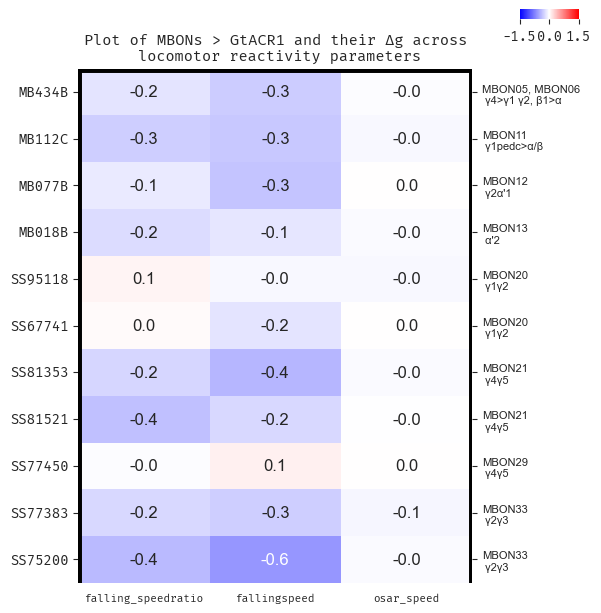

In [30]:
#mini list of only SPECIFIC responder

responder = "ACR"

if responder == 'Chrimson2':
    responderrename = "CsChrimson"
    dfreg_specificresponder = dfreg_co.sort_values(by = "responder", ascending=True).reset_index(drop=True)

if responder == 'ACR':
    responderrename = "GtACR1"
    dfreg_specificresponder = dfreg_ao.sort_values(by = "responder", ascending=True).reset_index(drop=True)

plt.rcParams["font.family"] = "Fira Mono"

lstofmbonsiwant = MBONList
df_specificmbon = pd.DataFrame()
for n in lstofmbonsiwant:
    df_specificmbon = pd.concat([df_specificmbon, dfreg_specificresponder[dfreg_specificresponder['MBON'] == n]])
    
df_specificmbon = df_specificmbon.reset_index(drop=True)
df60 = df_specificmbon.set_index(['MBON'])
df60 = df60.drop(['responder'], axis =1)
fig1, ax4 = plt.subplots(figsize=(6, 6))     

#adding extra axes label
lobloclst = []
mbonloclst = []
for n in df_specificmbon['MBON']:
    df600 = df_specificmbon.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df600['Lobe'] = lobloclst
df600['Name'] = mbonloclst

df600 = df600.sort_values(by = "Name", ascending=True).reset_index(drop=True)
df60extra = df600.iloc[:,:-3].set_index('MBON')   #change depending on parameters

newdf600 = pd.DataFrame()
naming = df600['Name'].to_frame().rename(columns = {"Name": ""})
lobing = df600['Lobe'].to_frame().rename(columns = {"Lobe": ""})
newlabel =(naming.values + "\n " + lobing.values).tolist()
newdf600['Merge'] = newlabel

#colorbar
cax = inset_axes(ax4,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.2, 1.15, 1, 1),
                 bbox_transform=ax4.transAxes,
                 borderpad=-2,
                 )

sns.set_style("whitegrid", {'axes.grid' : False})    
       
j7 = sns.heatmap(df60extra, ax = ax4, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='bwr', linewidths=0.0, edgecolor = "none"
                 , clip_on=False, cbar_ax=cax, cbar_kws = dict(orientation = "horizontal", ticks = [-1.5,0,1.5]), annot_kws={"size": 12, }) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #cbar_kws = dict(orientation = "vertical")
#twilight_shifted also a possible color

j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 10)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 8)
#j7.set_xticklabels(['Falling_Speed', 'Osar_Speed', 'Falling_Speedratio'], rotation = 0, fontsize = 8)

wrap_labels(j7, 10)

# Drawing the frame 
j7.axhline(y = 0, color = 'k',  
            linewidth = 5) 
  
j7.axhline(y = 12, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 0, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 3, color = 'k', 
            linewidth = 5) 

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())


#y labels for mbon lobes and naming
labellinglist = newdf600['Merge'].iloc[::-1]
labelledlist = []
for n in labellinglist:
    labelledlist.extend(n)
    #inserts blank space after every list name
j8.set_yticklabels(labelledlist, fontsize=8)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)

j7.set_title('Plot of MBONs > ' + responderrename +' and their Δg across\n locomotor reactivity parameters', x=0.5, weight='bold', fontsize =11)

fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations.png", dpi = 1200)

## OSAR to Falling Speed

In [224]:
full_light.columns

Index(['exptDate', 'driver', 'expt_time_start', 'genotype', 'opsin',
       'light_intensity', 'light_color', 'status',
       'reversals_to_light_BASELINE', 'traversals_to_light_BASELINE',
       'reversals_to_dark_BASELINE', 'traversals_to_dark_BASELINE',
       'light_attraction_index_BASELINE', 'pi_smoothed_BASELINE',
       'log2_speed_ratio_BASELINE', 'distance_in_light_BASELINE',
       'time_in_light_BASELINE', 'distance_in_dark_BASELINE',
       'time_in_dark_BASELINE', 'time_in_choice_zone_BASELINE',
       'speed_before_cross_to_dark_BASELINE',
       'speed_after_cross_to_dark_BASELINE',
       'speed_before_cross_to_light_BASELINE',
       'speed_after_cross_to_light_BASELINE', 'reversals_to_light_Pattern 01',
       'traversals_to_light_Pattern 01', 'reversals_to_dark_Pattern 01',
       'traversals_to_dark_Pattern 01', 'light_attraction_index_Pattern 01',
       'pi_smoothed_Pattern 01', 'log2_speed_ratio_Pattern 01',
       'distance_in_light_Pattern 01', 'time_in_light